<a href="https://colab.research.google.com/github/RENISA-GRACELIN/Online_Internship_Projects/blob/main/NewModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets

# Define the paths to your datasets
train_data_dir = '/content/drive/MyDrive/DR/Train'
valid_data_dir = '/content/drive/MyDrive/DR/Valid'
test_data_dir = '/content/drive/MyDrive/DR/Test'

# Define transforms for data augmentation and normalization
tform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.Resize((224, 224)),  # Resize to match input size of ResNet18
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Load the datasets
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=tform)
valid_dataset = datasets.ImageFolder(root=valid_data_dir, transform=tform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=tform)

# Combine train and validation datasets
combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset, valid_dataset])

# Define the batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use a pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Convert model to grayscale
model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1, bias=False)

# Update the fully connected layer based on the number of classes in the dataset
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))

model.to(device)

# Print model summary
print(model)

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/NewModel.h5')

# Specify the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Lists to store training and testing accuracy for plotting
Train_accuracy_list = []
Test_accuracy_list = []

# Define the training function
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(data_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    Train_accuracy_list.append(accuracy)  # Store accuracy for plotting
    print('Training Loss: {:.4f}, Accuracy: {:.2f}%'.format(running_loss / len(data_loader), accuracy))

# Define the testing function
def test_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    Test_accuracy_list.append(accuracy)  # Store accuracy for plotting
    print('Testing Accuracy: {:.2f}%'.format(accuracy))

# Train and test the model
num_epochs = 30
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    train_one_epoch(model, optimizer, train_loader, device)
    test_model(model, test_loader)

print('Finished Training')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 52.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

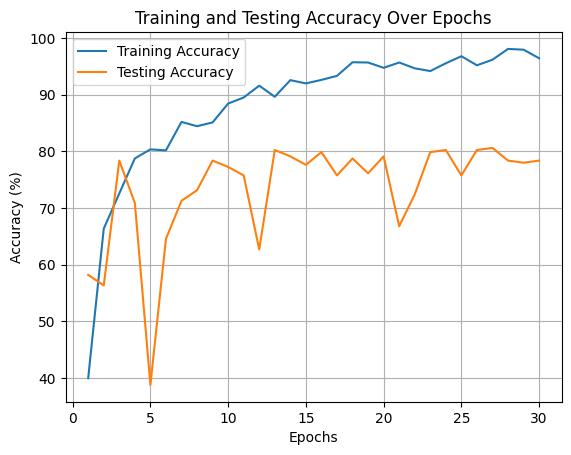

In [3]:
import matplotlib.pyplot as plt

# Assuming you have stored the accuracy values in variables
epochs = range(1, num_epochs+1)  # Assuming you trained for 100 epochs

# Plot the graph using your actual accuracy values
plt.plot(epochs, Train_accuracy_list, label='Training Accuracy')
plt.plot(epochs, Test_accuracy_list, label='Testing Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy Over Epochs')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


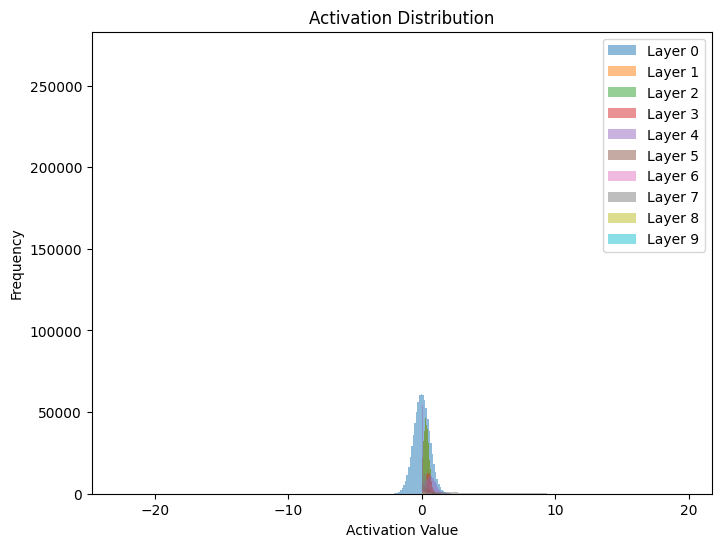

In [10]:
# Assuming you have a function to get activations
def get_activations(model, inputs):
    activations = []
    def hook(module, input, output):
        activations.append(output)
    handles = []
    for layer in model.children():
        handle = layer.register_forward_hook(hook)
        handles.append(handle)
    _ = model(inputs)
    for handle in handles:
        handle.remove()
    return activations

# Get activations
inputs = torch.randn(1, 3, 224, 224).to(device)  # Sample input
activations = get_activations(model, inputs)

# Plot activation distribution
plt.figure(figsize=(8, 6))
for activation in activations:
    plt.hist(activation.detach().cpu().numpy().flatten(), bins=50, alpha=0.5)
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.title('Activation Distribution')
plt.legend(['Layer {}'.format(i) for i in range(len(activations))])
plt.show()


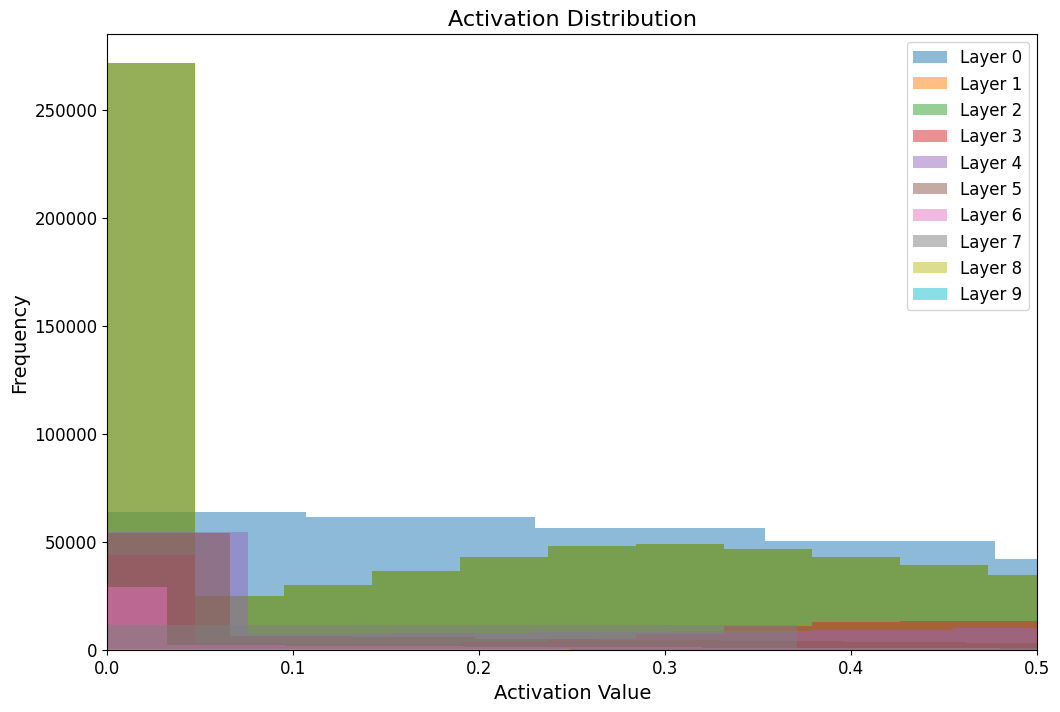

In [24]:
import matplotlib.pyplot as plt
import torch

# Assuming you have a function to get activations
def get_activations(model, inputs):
    activations = []
    def hook(module, input, output):
        activations.append(output)
    handles = []
    for layer in model.children():
        handle = layer.register_forward_hook(hook)
        handles.append(handle)
    _ = model(inputs)
    for handle in handles:
        handle.remove()
    return activations

# Get activations
inputs = torch.randn(1, 3, 224, 224).to(device)  # Sample input
activations = get_activations(model, inputs)

# Plot activation distribution
plt.figure(figsize=(12, 8))  # Increase the size of the figure
for activation in activations:
    plt.hist(activation.detach().cpu().numpy().flatten(), bins=50, alpha=0.5)
plt.xlabel('Activation Value', fontsize=14)  # Increase the font size of the x-axis label
plt.ylabel('Frequency', fontsize=14)  # Increase the font size of the y-axis label
plt.title('Activation Distribution', fontsize=16)  # Increase the font size of the title
plt.legend(['Layer {}'.format(i) for i in range(len(activations))], fontsize=12)  # Increase the font size of the legend
plt.xticks(fontsize=12)  # Increase the font size of the x-axis ticks
plt.yticks(fontsize=12)  # Increase the font size of the y-axis ticks

# Change the frequency value in x axis
plt.xlim(0, 0.5)  # Set the limits of the x-axis

plt.show()


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions and true labels
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.75      0.86      0.80        50
           1       0.81      0.69      0.75        68
           2       0.69      0.76      0.72        50
           3       1.00      0.92      0.96        50
           4       0.77      0.80      0.78        50

    accuracy                           0.80       268
   macro avg       0.80      0.81      0.80       268
weighted avg       0.81      0.80      0.80       268



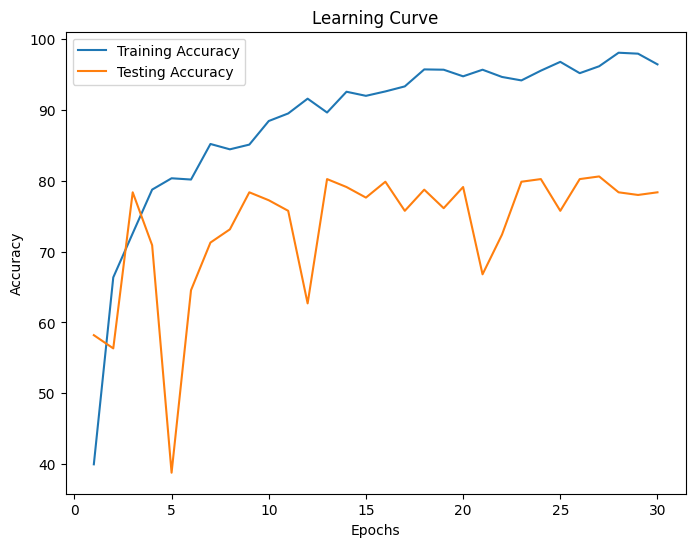

In [16]:
# Assuming you have stored training and testing accuracies in lists Train_accuracy_list and Test_accuracy_list
epochs = range(1, num_epochs+1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(epochs, Train_accuracy_list, label='Training Accuracy')
plt.plot(epochs, Test_accuracy_list, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()
